# ЛР №4. Линейные модели, SVM и деревья решений.

В качестве набора данных мы будем использовать следующий датасет - https://www.kaggle.com/adityakadiwal/water-potability. Будем решать задачу классификации для предсказания, безопасна ли вода для потребления человеком.

Нашей целевой переменной является Potability: 1 - пригодна для питья, 0 - не пригодна для питья.

## Подготовка

In [82]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
import numpy as np
from typing import Dict, Tuple

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.model_selection import validation_curve, learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz

In [18]:
data = pd.read_csv('water_potability.csv', sep=',')

In [19]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [21]:
data.duplicated().sum()

0

In [22]:
# Проверяем процент пропусков в данных для всех колонок
(data.isnull().sum()/data.shape[0]*100).sort_values(ascending=False)

Sulfate            23.840049
ph                 14.987790
Trihalomethanes     4.945055
Potability          0.000000
Turbidity           0.000000
Organic_carbon      0.000000
Conductivity        0.000000
Chloramines         0.000000
Solids              0.000000
Hardness            0.000000
dtype: float64

Удаляем столбцы sulfate и ph, поскольку процент пропусков достаточно высокий.

In [23]:
# Колонки для которых удаляются пропуски
cols_with_na_temp = ['Sulfate', 'ph']

In [24]:
# Удаление пропусков
data.drop(cols_with_na_temp, axis=1, inplace=True)

Для столбца Trihalomethanes выполним импьютацию показателями центра распределения, поскольку процент пропусков <5%.

In [31]:
#С помощью класса SimpleImputer можно проводить импьютацию различными показателями центра распределения
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data[['Trihalomethanes']])
imp_num = SimpleImputer(strategy='median')
data_num_imp = imp_num.fit_transform(data[['Trihalomethanes']])
data['Trihalomethanes'] =data_num_imp

In [32]:
# Проверяем процент пропусков в данных для всех колонок
(data.isnull().sum()/data.shape[0]*100).sort_values(ascending=False)

Potability         0.0
Turbidity          0.0
Trihalomethanes    0.0
Organic_carbon     0.0
Conductivity       0.0
Chloramines        0.0
Solids             0.0
Hardness           0.0
dtype: float64

In [34]:
#Выполняем масштабирование признаков
col_num = data.dtypes[data.dtypes!=object].index.values.tolist()
col_num.remove('Potability')
se = StandardScaler()
data[col_num] = se.fit_transform(data[col_num])

In [35]:
data.head()

,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.259195,-0.139471,0.112415,1.708954,-1.180651,1.305434,-1.286298,0
1,-2.036414,-0.385987,-0.307694,2.062575,0.270597,-0.639186,0.684218,0
2,0.847665,-0.240047,1.360594,-0.094032,0.781117,0.000800,-1.167365,0
3,0.547651,0.000493,0.592008,-0.778830,1.255134,2.152154,0.848412,0
4,-0.464429,-0.460249,-0.363698,-0.343939,-0.824357,-2.182297,0.138786,0


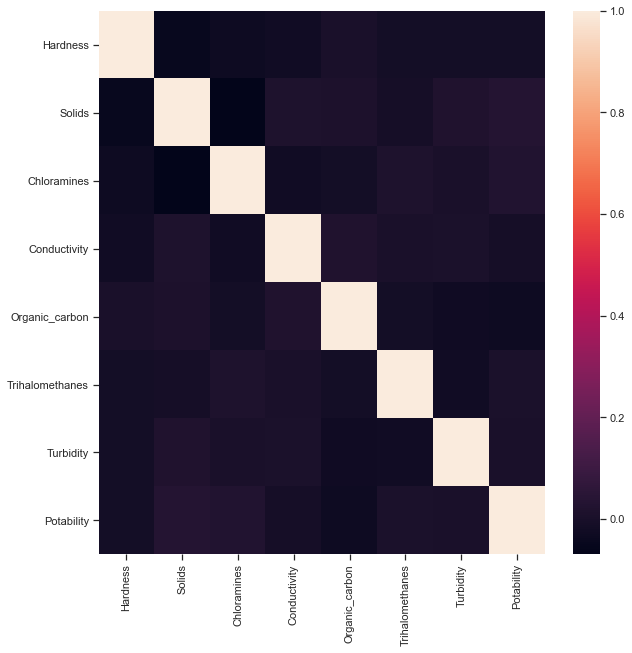

In [36]:
plt.figure(figsize=(10,10))
g = sns.heatmap(data.corr())

In [53]:
#удалим признак Organic_carbon, поскольку он слабее всех коррелирует с целевым
data_copy=data.copy()
dataD_copy = data_copy.drop(columns=['Organic_carbon'])
dataD = data.drop(columns=['Organic_carbon'])

In [54]:
dataD.head()

,Hardness,Solids,Chloramines,Conductivity,Trihalomethanes,Turbidity,Potability
0,0.259195,-0.139471,0.112415,1.708954,1.305434,-1.286298,0
1,-2.036414,-0.385987,-0.307694,2.062575,-0.639186,0.684218,0
2,0.847665,-0.240047,1.360594,-0.094032,0.000800,-1.167365,0
3,0.547651,0.000493,0.592008,-0.778830,2.152154,0.848412,0
4,-0.464429,-0.460249,-0.363698,-0.343939,-2.182297,0.138786,0


In [44]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    labels, counts = np.unique(array, return_counts=True)
    counts_perc = counts/array.size
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [66]:
TEST_SIZE = 0.3
RANDOM_STATE = 0
SPLITS_DEFAULT = 5
CROSS_VAL = StratifiedKFold(n_splits=SPLITS_DEFAULT)

In [56]:
data_X = data.drop(columns='Potability')
data_y = data['Potability']
dataD_X = dataD.drop(columns='Potability')
dataD_y = dataD['Potability']

In [57]:
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(data_X, \
                                                                        data_y, test_size=TEST_SIZE, \
                                                                        random_state=RANDOM_STATE)
dataD_X_train, dataD_X_test, dataD_y_train, dataD_y_test = train_test_split(dataD_X, \
                                                                        dataD_y, test_size=TEST_SIZE, \
                                                                        random_state=RANDOM_STATE)

In [58]:
print_class_proportions(data_y_train)

Метка 	 Количество 	 Процент встречаемости
0 	 1388 	 	 60.53%
1 	 905 	 	 39.47%


In [59]:
print_class_proportions(data_y_test)

Метка 	 Количество 	 Процент встречаемости
0 	 610 	 	 62.05%
1 	 373 	 	 37.95%


In [61]:
def print_metrics(X_train, Y_train, X_test, Y_test, clf):
    clf.fit(X_train, Y_train)
    target = clf.predict(X_test)
    ret = balanced_accuracy_score(Y_test, target)
    print(f'Сбалансированная оценка: {ret}')
    plot_roc_curve(clf, X_test, Y_test)
    plt.show()
    print(f'Матрица ошибок:\n {confusion_matrix(Y_test, target)}')
    print(classification_report(Y_test, target, target_names=['1', '0']))
    return ret

In [62]:
def print_gridResults(grid, p):
    print(f'Подобранный параметр: {grid.best_params_}')
    print(f'Оценка при подобранном параметре: {grid.best_score_}')
    return [grid.best_params_[p], grid.best_score_]

In [63]:
def get_optimum(clf, dist, n_iter, data_X_train, data_y_train, scoring='balanced_accuracy'):
    Random_grid = RandomizedSearchCV(clf, dist, n_iter=n_iter, \
                                      scoring=scoring, cv=CROSS_VAL, random_state=RANDOM_STATE)
    Random_grid.fit(data_X_train, data_y_train)
    res = print_gridResults(Random_grid, list(dist.keys())[0])
    return res

## Logistic Regression

In [64]:
LogReg_param = {"C":uniform(loc=0, scale=100)}  # равномерное распределение между 0 и 100

### 1. Удален признак Organic_carbon

In [67]:
linearD = get_optimum(LogisticRegression(max_iter=10000), LogReg_param, 20, dataD_X_train, dataD_y_train)

Подобранный параметр: {'C': 54.88135039273247}
Оценка при подобранном параметре: 0.4998330617274137


Сбалансированная оценка: 0.5


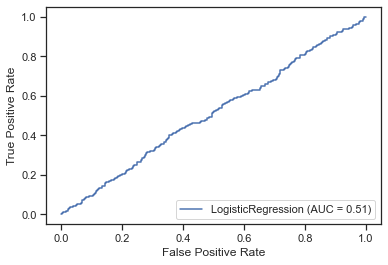

Матрица ошибок:
 [[610   0]
 [373   0]]
              precision    recall  f1-score   support

           1       0.62      1.00      0.77       610
           0       0.00      0.00      0.00       373

    accuracy                           0.62       983
   macro avg       0.31      0.50      0.38       983
weighted avg       0.39      0.62      0.48       983



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
LRd = print_metrics(dataD_X_train, dataD_y_train, dataD_X_test, dataD_y_test, LogisticRegression(C=linearD[0], max_iter=10000))

### 2. Не удален признак Organic_carbon

In [69]:
linear = get_optimum(LogisticRegression(max_iter=10000), LogReg_param, 20, data_X_train, data_y_train)

Подобранный параметр: {'C': 54.88135039273247}
Оценка при подобранном параметре: 0.4994733494971978


Сбалансированная оценка: 0.5


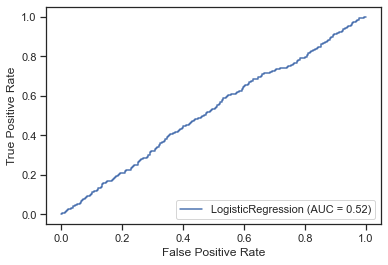

Матрица ошибок:
 [[610   0]
 [373   0]]
              precision    recall  f1-score   support

           1       0.62      1.00      0.77       610
           0       0.00      0.00      0.00       373

    accuracy                           0.62       983
   macro avg       0.31      0.50      0.38       983
weighted avg       0.39      0.62      0.48       983



C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
LR = print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, LogisticRegression(C=linear[0], max_iter=10000))

## SVM

In [71]:
SVM_param = {"C":uniform(loc=0, scale=100)}  # равномерное распределение между 0 и 100

### 1. Удален признак Organic_carbon

In [72]:
svmD = get_optimum(SVC(random_state=RANDOM_STATE), SVM_param, 3, dataD_X_train, dataD_y_train)

Подобранный параметр: {'C': 71.51893663724195}
Оценка при подобранном параметре: 0.5268194571334973


Сбалансированная оценка: 0.5352349140772645


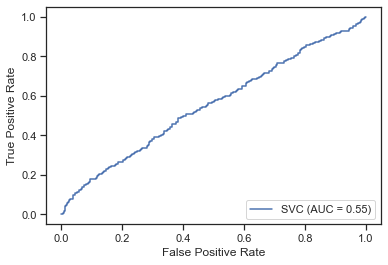

Матрица ошибок:
 [[478 132]
 [266 107]]
              precision    recall  f1-score   support

           1       0.64      0.78      0.71       610
           0       0.45      0.29      0.35       373

    accuracy                           0.60       983
   macro avg       0.55      0.54      0.53       983
weighted avg       0.57      0.60      0.57       983



In [73]:
SVMd = print_metrics(dataD_X_train, dataD_y_train, dataD_X_test, dataD_y_test, SVC(random_state=RANDOM_STATE, C=svmD[0]))

### 2. Не удален признак Organic_carbon

In [74]:
svm = get_optimum(SVC(random_state=RANDOM_STATE), SVM_param, 3, data_X_train, data_y_train)

Подобранный параметр: {'C': 60.276337607164386}
Оценка при подобранном параметре: 0.526148360685965


Сбалансированная оценка: 0.5296334549290204


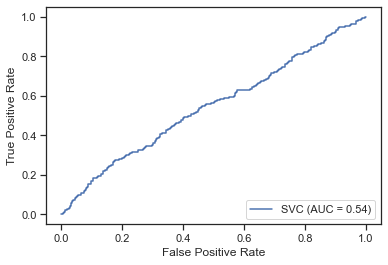

Матрица ошибок:
 [[445 165]
 [250 123]]
              precision    recall  f1-score   support

           1       0.64      0.73      0.68       610
           0       0.43      0.33      0.37       373

    accuracy                           0.58       983
   macro avg       0.53      0.53      0.53       983
weighted avg       0.56      0.58      0.56       983



In [75]:
SVM = print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, SVC(random_state=RANDOM_STATE, C=svm[0]))

## Дерево решений

In [76]:
Tree_param = {"max_depth":randint(1, 10)}  # целочисленное распределение между 1 и 10

### 1. Удален признак Organic_carbon

In [77]:
treeD = get_optimum(DecisionTreeClassifier(random_state=RANDOM_STATE), Tree_param, 10, dataD_X_train, dataD_y_train)

Подобранный параметр: {'max_depth': 5}
Оценка при подобранном параметре: 0.505404895621967


Сбалансированная оценка: 0.5149233068166835


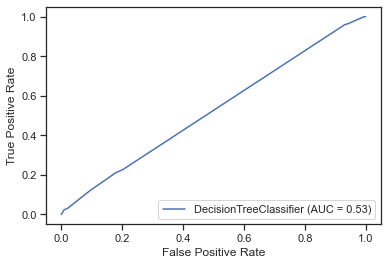

Матрица ошибок:
 [[517  93]
 [305  68]]
              precision    recall  f1-score   support

           1       0.63      0.85      0.72       610
           0       0.42      0.18      0.25       373

    accuracy                           0.60       983
   macro avg       0.53      0.51      0.49       983
weighted avg       0.55      0.60      0.54       983



In [78]:
DTd = print_metrics(dataD_X_train, dataD_y_train, dataD_X_test, dataD_y_test, DecisionTreeClassifier(max_depth=treeD[0], \
                                                                                               random_state=RANDOM_STATE))

In [79]:
tr_clfD = DecisionTreeClassifier(max_depth=treeD[0], random_state=RANDOM_STATE)
tr_clfD.fit(dataD_X_train, dataD_y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

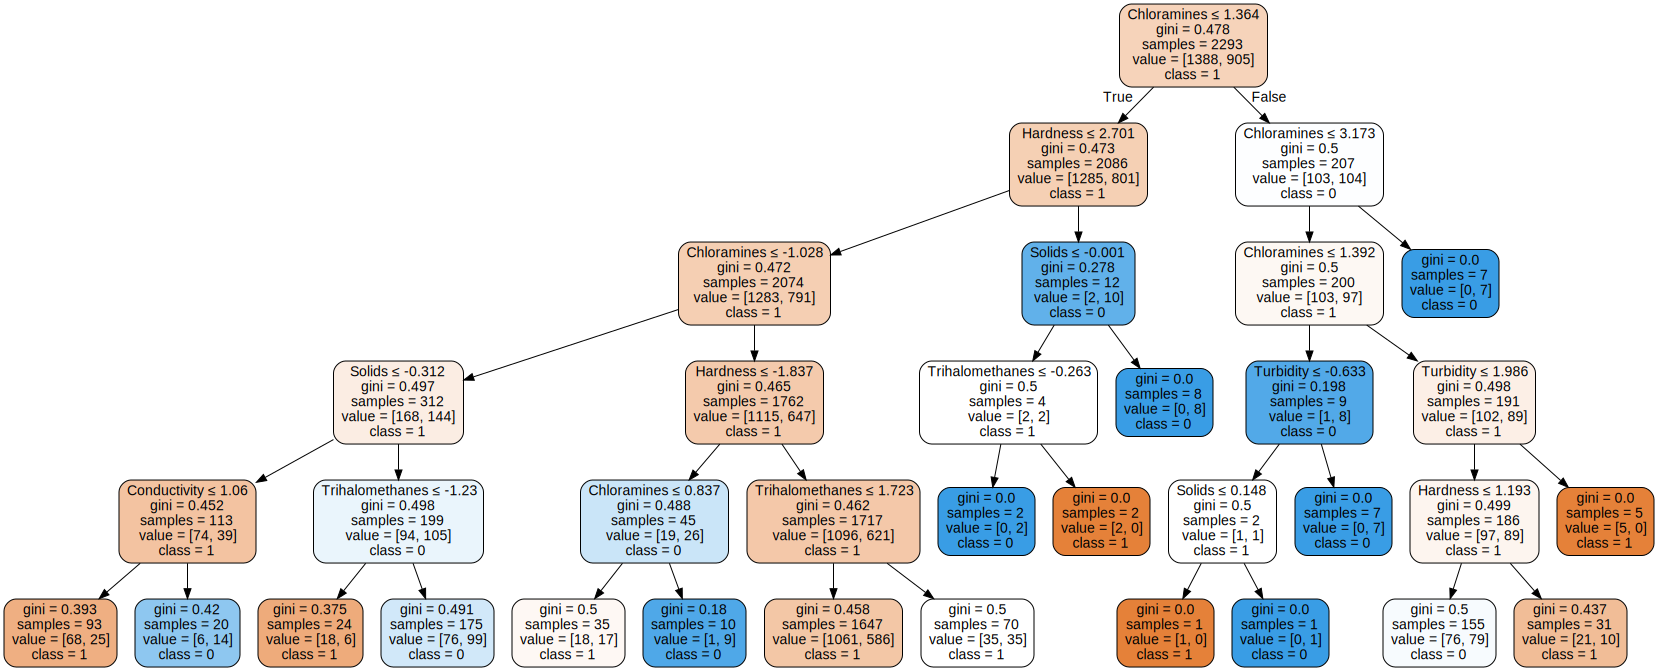

In [104]:
dot_data = export_graphviz(tr_clfD, out_file=None, 
                           feature_names=dataD_X_train.columns.tolist(), 
                           class_names=['1', '0'], 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

In [85]:
def show_feature_importance(importance, col_names):
    data = pd.DataFrame({'feature_names':np.array(col_names),'feature_importance':np.array(importance)})
    data.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,7))
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    plt.title('Feature importance using DecisionTreeClassifier')
    plt.xlabel('importance')
    plt.ylabel('name')

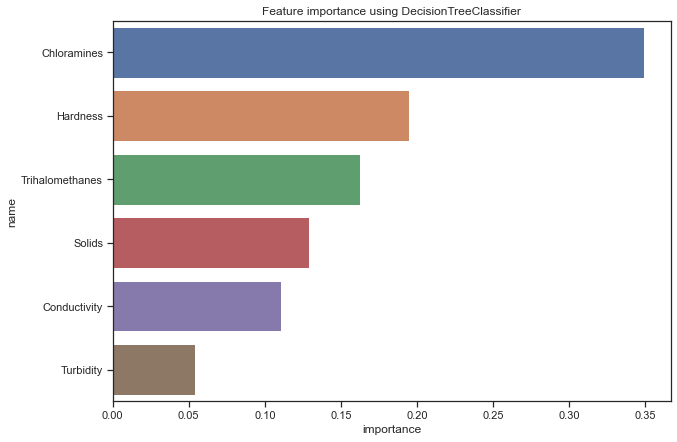

In [86]:
show_feature_importance(tr_clfD.feature_importances_, dataD_X_train.columns.tolist())

### 2. Не удален признак Organic_carbon

In [87]:
tree = get_optimum(DecisionTreeClassifier(random_state=RANDOM_STATE), Tree_param, 10, data_X_train, data_y_train)

Подобранный параметр: {'max_depth': 5}
Оценка при подобранном параметре: 0.5037487356585403


Сбалансированная оценка: 0.5085109655869555


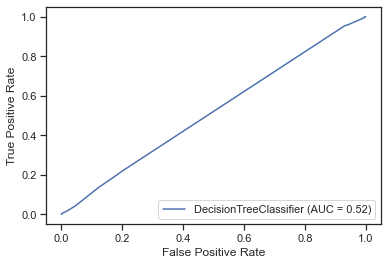

Матрица ошибок:
 [[501 109]
 [300  73]]
              precision    recall  f1-score   support

           1       0.63      0.82      0.71       610
           0       0.40      0.20      0.26       373

    accuracy                           0.58       983
   macro avg       0.51      0.51      0.49       983
weighted avg       0.54      0.58      0.54       983



In [88]:
DT = print_metrics(data_X_train, data_y_train, data_X_test, data_y_test, DecisionTreeClassifier(max_depth=tree[0], \
                                                                                               random_state=RANDOM_STATE))

In [89]:
tr_clf = DecisionTreeClassifier(max_depth=tree[0], random_state=RANDOM_STATE)
tr_clf.fit(data_X_train, data_y_train)

DecisionTreeClassifier(max_depth=5, random_state=0)

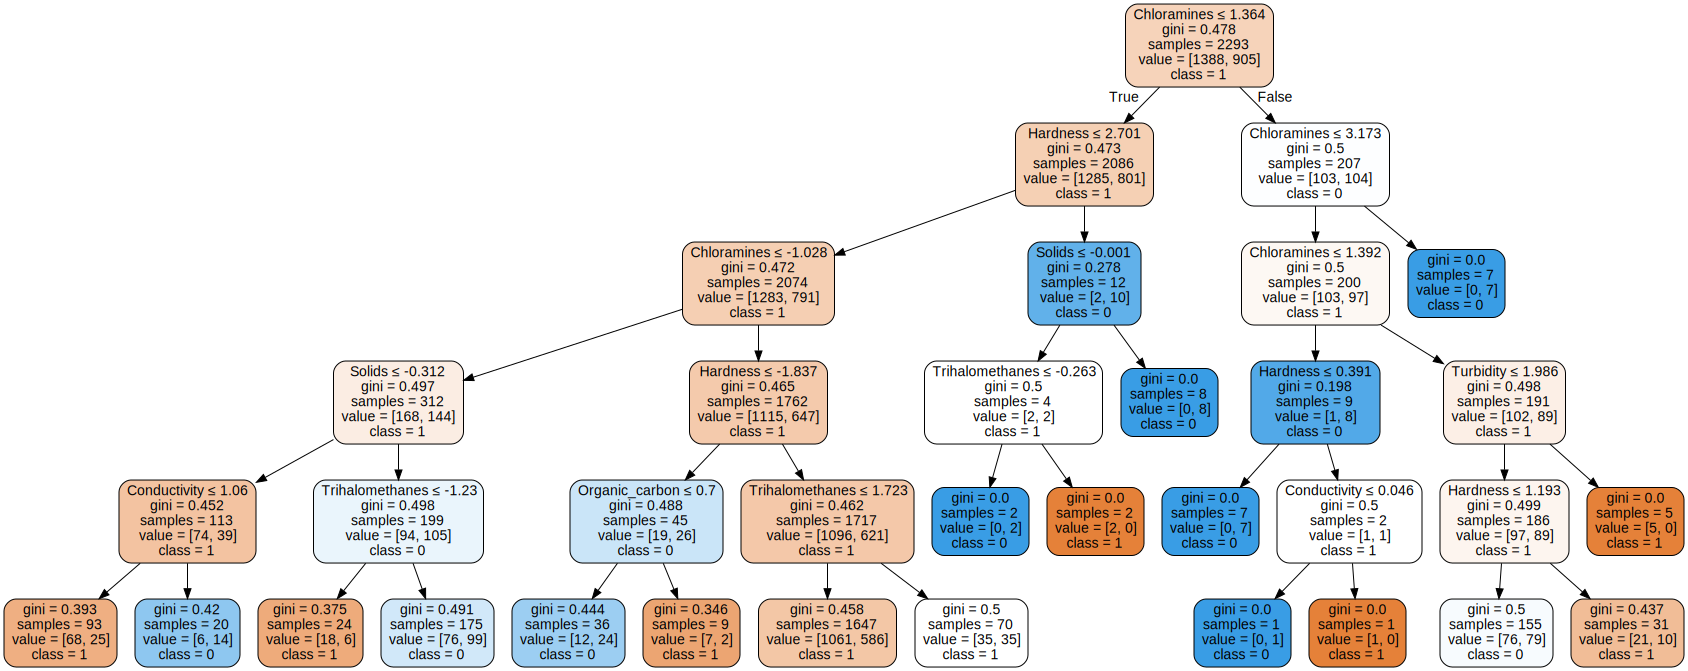

In [91]:
dot_data = export_graphviz(tr_clf, out_file=None, 
                           feature_names=data_X_train.columns.tolist(), 
                           class_names=['1', '0'], 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

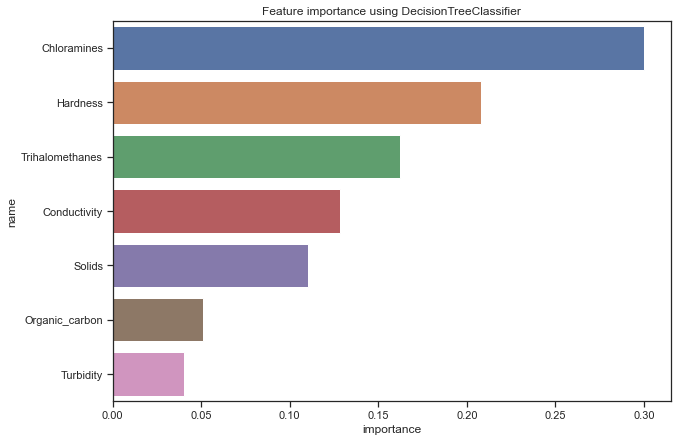

In [92]:
show_feature_importance(tr_clf.feature_importances_, data_X_train.columns.tolist())

## Итоги

In [94]:
lst_label_cv = ['LR', 'SVM', 'DT']
dc_score = {'Удален признак Organic_carbon':[LRd, SVMd, DTd],\
           'Не удален признак Organic_carbon':[LR, SVM, DT]}

### 1. Метрика balanced_accuracy

In [95]:
pd.DataFrame(dc_score, index=lst_label_cv)

,Удален признак Organic_carbon,Не удален признак Organic_carbon
LR,0.500000,0.500000
SVM,0.535235,0.529633
DT,0.514923,0.508511


### 2. Метрика ROC_CURVE

###  Удален признак Organic_carbon

#### LR

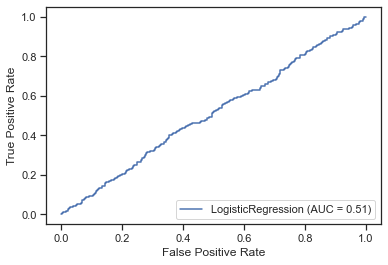

In [96]:
plot_roc_curve(LogisticRegression(C=linearD[0], max_iter=10000).fit(dataD_X_train, dataD_y_train), \
               dataD_X_test, dataD_y_test)

#### SVM

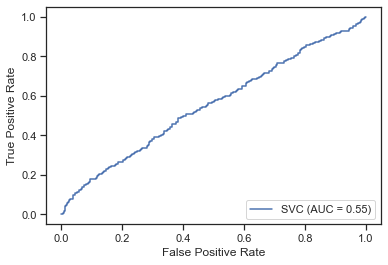

In [97]:
plot_roc_curve(SVC(random_state=RANDOM_STATE, C=svmD[0]).fit(dataD_X_train, dataD_y_train), \
               dataD_X_test, dataD_y_test)

#### DT

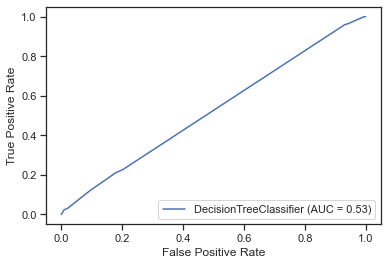

In [99]:
plot_roc_curve(DecisionTreeClassifier(max_depth=treeD[0], random_state=RANDOM_STATE).fit(dataD_X_train, \
               dataD_y_train), dataD_X_test, dataD_y_test)

###  Не удален признак Organic_carbon

#### LR

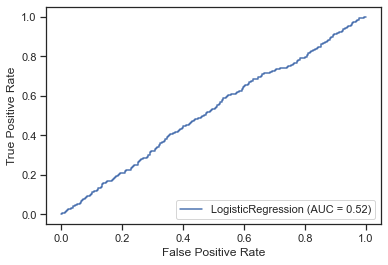

In [100]:
plot_roc_curve(LogisticRegression(C=linear[0], max_iter=10000).fit(data_X_train, data_y_train), \
               data_X_test, data_y_test)

#### SVM

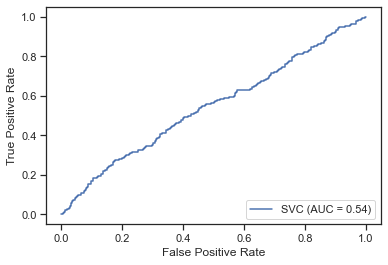

In [101]:
plot_roc_curve(SVC(random_state=RANDOM_STATE, C=svm[0]).fit(data_X_train, data_y_train), data_X_test, data_y_test)

#### DT

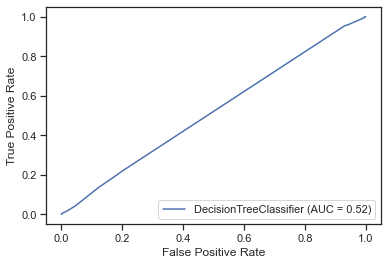

In [102]:
plot_roc_curve(DecisionTreeClassifier(max_depth=tree[0], random_state=RANDOM_STATE).fit(data_X_train, \
               data_y_train), data_X_test, data_y_test)